# Candidate Groups by Domain and Step Relative Position

This notebook builds candidate group tables from the dataset in `data/WebPRMCollection_preference_pair_8k_test.json`:
- Domains summary by `website_name`
- Candidate groups by `website_name` and step relative position quartiles
- Three-way domain tertiles (equal number of domains per group)


## 1) Setup paths and outputs
- Define project root, dataset path, and results directory
- Create output directory if missing


In [1]:
from pathlib import Path

def find_project_root() -> Path:
    cwd = Path.cwd().resolve()
    for p in [cwd, *cwd.parents]:
        if (p / "data").exists() and (p / "analysis").exists():
            return p
    return cwd  # fallback

PROJECT_ROOT = find_project_root()
DATA_PATH = PROJECT_ROOT / "data" / "WebPRMCollection_preference_pair_8k_test.json"
OUT_DIR = PROJECT_ROOT / "analysis" / "results"
OUT_DIR.mkdir(parents=True, exist_ok=True)

DATA_PATH, OUT_DIR

(PosixPath('/home/zeyuli/Code/VisualAgentBench/data/WebPRMCollection_preference_pair_8k_test.json'),
 PosixPath('/home/zeyuli/Code/VisualAgentBench/analysis/results'))

## 2) Helper functions
- `_safe_int`, `_rel_bin`, `load_dataset`, `compute_task_ranges`
- Support robust parsing and relative positioning.


In [2]:
from typing import Any, Dict, List, Tuple
import json
from pathlib import Path
import pandas as pd

def _safe_int(x: Any, default: int = 0) -> int:
    try:
        if isinstance(x, bool):
            return default
        return int(str(x).strip())
    except Exception:
        return default


def _rel_bin(rel: float) -> str:
    if rel < 0.25:
        return "Q1_0-25%"
    if rel < 0.50:
        return "Q2_25-50%"
    if rel < 0.75:
        return "Q3_50-75%"
    return "Q4_75-100%"


def load_dataset(path: Path) -> List[Dict[str, Any]]:
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)


def compute_task_ranges(rows: List[Dict[str, Any]]) -> Dict[str, Tuple[int, int]]:
    ranges: Dict[str, Tuple[int, int]] = {}
    for r in rows:
        task_id = str(r.get("task_id", ""))
        step_id = _safe_int(r.get("step_id", 0))
        if not task_id:
            continue
        if task_id not in ranges:
            ranges[task_id] = (step_id, step_id)
        else:
            lo, hi = ranges[task_id]
            if step_id < lo:
                lo = step_id
            if step_id > hi:
                hi = step_id
            ranges[task_id] = (lo, hi)
    return ranges


## 3) Load dataset and preview
- Loads rows from `DATA_PATH` to memory.
- Quick peek of key fields to confirm schema.


In [3]:
rows = load_dataset(DATA_PATH)
len(rows), rows[0].keys() if rows else None


(8000,
 dict_keys(['task_id', 'step_id', 'intent', 'website_name', 'start_url', 'thought_history', 'action_history', 'current_url', 'text_observation', 'checklist', 'checklist_target_list', 'chosen', 'rejected', 'prefer']))

## 4) Domains summary (website_name)
- Aggregate counts per `website_name` to understand domain distribution.
- Output: `analysis/results/domains_summary.csv`


## 5) Relative position quartiles per domain
- Compute normalized relative step position per `task_id`:
  - If single-step task: `rel=0.0`.
  - Else: `rel=(step_id-min_step)/(max_step-min_step)`.
- Bin `rel` into: `[0,0.25)`, `[0.25,0.5)`, `[0.5,0.75)`, `[0.75,1.0]`.
- Group by `(website_name, rel_bin)` to get `count` and `pct_within_domain`.
- Output: `analysis/results/candidate_groups.csv`


In [4]:
# Domains summary
import pandas as pd

domain_counts = (
    pd.Series([str(r.get("website_name", "unknown")).strip() or "unknown" for r in rows])
      .value_counts()
      .rename_axis("website_name")
      .reset_index(name="count")
)

domain_counts.to_csv(OUT_DIR / "domains_summary.csv", index=False)
domain_counts.head(10)


,website_name,count
0,wanderu,278
1,ikea,270
2,costco,259
3,ryanair,242
4,rentalcars,239
5,spothero,232
6,gamespot,226
7,scotts,220
8,emirates,219
9,boardgamegeek,219


In [5]:
# Relative position bins per domain
tranges = compute_task_ranges(rows)

records = []
for r in rows:
    website = str(r.get("website_name", "unknown")).strip() or "unknown"
    task_id = str(r.get("task_id", ""))
    step_id = _safe_int(r.get("step_id", 0))
    lo, hi = tranges.get(task_id, (0, 0))
    denom = max(1, hi - lo)
    rel = 0.0 if hi == lo else (step_id - lo) / denom
    records.append({"website_name": website, "rel": rel, "rel_bin": _rel_bin(rel)})

rel_df = pd.DataFrame.from_records(records)
# group counts and within-domain percentage
agg = (
    rel_df.groupby(["website_name", "rel_bin"]).size().rename("count").reset_index()
)
agg["within_total"] = agg.groupby("website_name")["count"].transform("sum")
agg["pct_within_domain"] = agg["count"] / agg["within_total"]

agg.sort_values(["website_name", "rel_bin"]).to_csv(OUT_DIR / "candidate_groups.csv", index=False)
agg.head(12)


,website_name,rel_bin,count,within_total,pct_within_domain
0,agoda,Q1_0-25%,11,48,0.229167
1,agoda,Q2_25-50%,8,48,0.166667
2,agoda,Q3_50-75%,8,48,0.166667
3,agoda,Q4_75-100%,21,48,0.437500
4,aircanada,Q1_0-25%,61,217,0.281106
5,aircanada,Q2_25-50%,39,217,0.179724
6,aircanada,Q3_50-75%,55,217,0.253456
7,aircanada,Q4_75-100%,62,217,0.285714
8,amazon,Q1_0-25%,46,158,0.291139
9,amazon,Q2_25-50%,32,158,0.202532


## 6) Domain tertiles (equal number of domains)
- Sort domains by count (descending) and split domain list into three groups with nearly equal number of domains.
- Labels: `G1_High`, `G2_Mid`, `G3_Low`.
- Note: equal by domain count, not by total samples per group.
- Output: `analysis/results/domain_groups_tertiles.csv`


In [6]:
# Domain tertiles (equal number of domains per group)
sorted_domains = domain_counts.sort_values("count", ascending=False).reset_index(drop=True)
N = len(sorted_domains)
if N > 0:
    k = N // 3
    r = N % 3
    sizes = [k + (1 if i < r else 0) for i in range(3)]
    labels = ["G1_High", "G2_Mid", "G3_Low"]
    groups = []
    idx = 0
    for gi, sz in enumerate(sizes):
        for _ in range(sz):
            if idx >= N:
                break
            groups.append(labels[gi])
            idx += 1
    sorted_domains["group"] = groups
else:
    sorted_domains["group"] = []

sorted_domains.to_csv(OUT_DIR / "domain_groups_tertiles.csv", index=False)
sorted_domains.head(10)


,website_name,count,group
0,wanderu,278,G1_High
1,ikea,270,G1_High
2,costco,259,G1_High
3,ryanair,242,G1_High
4,rentalcars,239,G1_High
5,spothero,232,G1_High
6,gamespot,226,G1_High
7,scotts,220,G1_High
8,emirates,219,G1_High
9,boardgamegeek,219,G1_High


In [7]:
# Assign every row to 12 buckets = 3 (domain tertiles) x 4 (relative position quartiles)
import json
import pandas as pd
from pathlib import Path

# 1) Load domain tertiles mapping
tertiles_df = pd.read_csv(OUT_DIR / "domain_groups_tertiles.csv")  # website_name,count,group
domain_group_map = dict(zip(tertiles_df["website_name"], tertiles_df["group"]))

# 2) Build per-row rel_bin again (with row_idx)
records = []
tranges = compute_task_ranges(rows)
for i, r in enumerate(rows):
    website = str(r.get("website_name", "unknown")).strip() or "unknown"
    task_id = str(r.get("task_id", ""))
    step_id = _safe_int(r.get("step_id", 0))
    lo, hi = tranges.get(task_id, (0, 0))
    denom = max(1, hi - lo)
    rel = 0.0 if hi == lo else (step_id - lo) / denom
    records.append({
        "row_idx": i,
        "website_name": website,
        "rel_bin": _rel_bin(rel),
    })

rel_df = pd.DataFrame.from_records(records)

# 3) Attach domain tertile group and form 12 buckets
rel_df["group"] = rel_df["website_name"].map(domain_group_map).fillna("G3_Low")
rel_df["bucket"] = rel_df["group"] + "|" + rel_df["rel_bin"]

# 4) Save assignments per row and bucket counts
assignments = rel_df[["row_idx","website_name","group","rel_bin","bucket"]].sort_values("row_idx")
assignments.to_csv(OUT_DIR / "row_bucket_assignments.csv", index=False)

bucket_counts = assignments["bucket"].value_counts().rename_axis("bucket").reset_index(name="count")
bucket_counts.to_csv(OUT_DIR / "bucket_counts.csv", index=False)

# 5) Optional: write one JSON per bucket under analysis/results/buckets/
out_dir_buckets = OUT_DIR / "buckets"
out_dir_buckets.mkdir(parents=True, exist_ok=True)

bucket_to_indices = assignments.groupby("bucket")["row_idx"].apply(list)
for bucket, idx_list in bucket_to_indices.items():
    shard = [rows[i] for i in idx_list]
    with open(out_dir_buckets / f"{bucket.replace('|','__')}.json", "w", encoding="utf-8") as f:
        json.dump(shard, f, ensure_ascii=False, indent=2)

bucket_counts


,bucket,count
0,G1_High|Q4_75-100%,1166
1,G1_High|Q1_0-25%,1069
2,G2_Mid|Q4_75-100%,856
3,G1_High|Q3_50-75%,821
4,G1_High|Q2_25-50%,777
5,G2_Mid|Q1_0-25%,750
6,G2_Mid|Q3_50-75%,568
7,G2_Mid|Q2_25-50%,551
8,G3_Low|Q4_75-100%,515
9,G3_Low|Q1_0-25%,439


## 7) Visualizations
- Domain tertile group sizes (G1/G2/G3)
- Stacked distribution of relative bins per domain group
- 12-bucket counts (3x4)
- 3x4 heatmap (group × rel_bin)


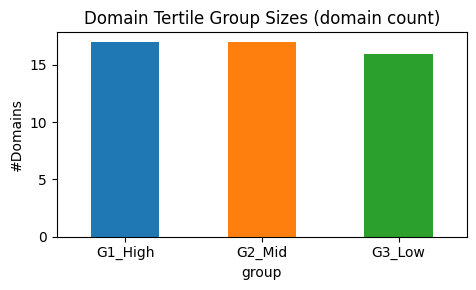

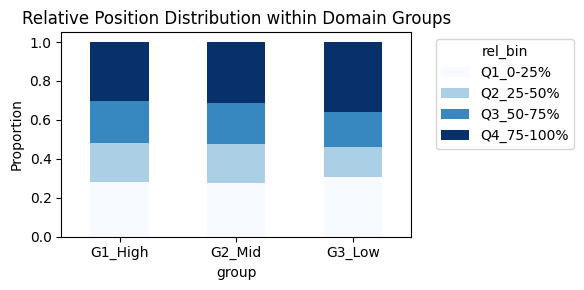

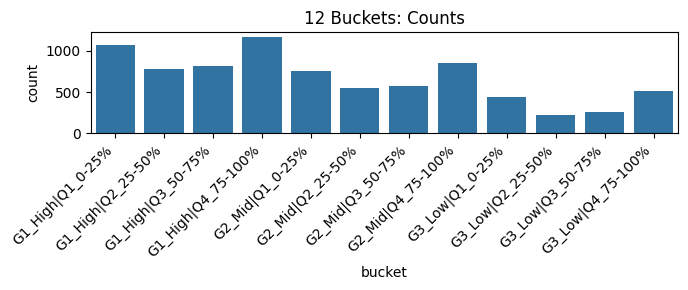

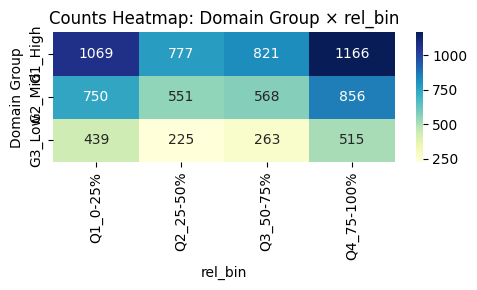

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure we have assignments and bucket counts
assignments = pd.read_csv(OUT_DIR / "row_bucket_assignments.csv")
bucket_counts = pd.read_csv(OUT_DIR / "bucket_counts.csv")
tertiles_df = pd.read_csv(OUT_DIR / "domain_groups_tertiles.csv")

# 1) Domain tertile group sizes
plt.figure(figsize=(5,3))
(tertiles_df["group"].value_counts()
    .reindex(["G1_High","G2_Mid","G3_Low"])
    .plot(kind="bar", color=["#1f77b4","#ff7f0e","#2ca02c"]))
plt.title("Domain Tertile Group Sizes (domain count)")
plt.ylabel("#Domains")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 2) Stacked distribution of rel_bin per domain group
# Build per-row domain group
domain_group_map = dict(zip(tertiles_df["website_name"], tertiles_df["group"]))
assignments["group"] = assignments["website_name"].map(domain_group_map).fillna("G3_Low")

stack_df = (assignments.groupby(["group","rel_bin"]).size()
            .rename("count").reset_index())
stack_pivot = stack_df.pivot(index="group", columns="rel_bin", values="count").fillna(0)
stack_pivot = stack_pivot.reindex(index=["G1_High","G2_Mid","G3_Low"],
                                  columns=["Q1_0-25%","Q2_25-50%","Q3_50-75%","Q4_75-100%"])

stack_pivot.div(stack_pivot.sum(axis=1), axis=0).plot(kind="bar", stacked=True, figsize=(6,3), colormap="Blues")
plt.title("Relative Position Distribution within Domain Groups")
plt.ylabel("Proportion")
plt.xticks(rotation=0)
plt.legend(title="rel_bin", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# 3) 12-bucket counts (3x4)
plt.figure(figsize=(7,3))
order = [f"{g}|{q}" for g in ["G1_High","G2_Mid","G3_Low"] for q in ["Q1_0-25%","Q2_25-50%","Q3_50-75%","Q4_75-100%"]]
plot_counts = bucket_counts.set_index("bucket").reindex(order).reset_index()
sns.barplot(data=plot_counts, x="bucket", y="count", color="#1f77b4")
plt.xticks(rotation=45, ha="right")
plt.title("12 Buckets: Counts")
plt.tight_layout()
plt.show()

# 4) 3x4 heatmap (group × rel_bin)
heat_df = assignments.groupby(["group","rel_bin"]).size().rename("count").reset_index()
heat_pivot = heat_df.pivot(index="group", columns="rel_bin", values="count").fillna(0)
heat_pivot = heat_pivot.reindex(index=["G1_High","G2_Mid","G3_Low"],
                                columns=["Q1_0-25%","Q2_25-50%","Q3_50-75%","Q4_75-100%"])
plt.figure(figsize=(5,3))
sns.heatmap(heat_pivot, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Counts Heatmap: Domain Group × rel_bin")
plt.ylabel("Domain Group")
plt.xlabel("rel_bin")
plt.tight_layout()
plt.show()


In [9]:
# 8) Navigation candidates (guaranteed URL change)
# - Identify link elements that likely navigate (absolute URLs, not anchors/js),
#   preferring detail-like paths (e.g., .html or explicit keywords)
# - Output: analysis/results/navigation_candidates.csv

import sys
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
from analysis.pipeline_utils import find_navigation_link_ids, pick_navigation_rejected_action
import pandas as pd

candidates = []
for i, r in enumerate(rows):
    text = str(r.get("text_observation", "") or "")
    cur_url = str(r.get("current_url", "") or r.get("start_url", "") or "")
    if not text or not cur_url:
        continue
    items = find_navigation_link_ids(text, cur_url, prefer_path_keywords=["/shop/", ".html"])  # adjust keywords per site
    if not items:
        continue
    eid, label, url = items[0]
    candidates.append({
        "row_idx": i,
        "task_id": str(r.get("task_id", "")),
        "step_id": str(r.get("step_id", "")),
        "website_name": str(r.get("website_name", "")),
        "current_url": cur_url,
        "candidate_eid": eid,
        "candidate_label": label,
        "candidate_url": url,
        "num_candidates": len(items),
    })

cand_df = pd.DataFrame.from_records(candidates)
out_path = OUT_DIR / "navigation_candidates.csv"
cand_df.to_csv(out_path, index=False)
len(cand_df), cand_df.head(10)


(7004,
    row_idx task_id step_id    website_name  \
 0        0    1326       3     infatuation   
 1        1     816       0         quandoo   
 2        2    1218       9     freshdirect   
 3        3     195      13         ryanair   
 4        4     844       8      soundcloud   
 5        5     592      11  bleacherreport   
 6        6    1695      14         truecar   
 7        7     195      11         ryanair   
 8        8    1296       2            imdb   
 9        9     440       0         last.fm   
 
                                          current_url candidate_eid  \
 0             https://www.theinfatuation.com/atlanta           202   
 1                         https://www.quandoo.co.uk/           136   
 2  https://www.freshdirect.com/fresh_produce/fru/...          7497   
 3  https://airporttransfers.ryanair.com/ie/search...            26   
 4         https://soundcloud.com/arianagrande/albums           734   
 5                    https://www.bleacherreport

In [10]:
# 9) Write filtered bucket shards (only rows with navigation candidates)
# - For each existing bucket shard, create a sibling file with `__filtered.json`
#   that only includes rows found in `navigation_candidates` (cand_df)

import pandas as pd

# Ensure we have assignments and cand_df
if 'assignments' not in globals():
    assignments = pd.read_csv(OUT_DIR / 'row_bucket_assignments.csv')

row_idx_has_nav = set(cand_df['row_idx'].tolist()) if 'cand_df' in globals() else set()

bucket_to_indices = assignments.groupby('bucket')['row_idx'].apply(list)

written = []
for bucket, idx_list in bucket_to_indices.items():
    filtered_rows = [rows[i] for i in idx_list if i in row_idx_has_nav]
    out_path = OUT_DIR / 'buckets' / f"{bucket.replace('|','__')}__filtered.json"
    with open(out_path, 'w', encoding='utf-8') as f:
        import json
        json.dump(filtered_rows, f, ensure_ascii=False, indent=2)
    written.append((bucket, len(filtered_rows), str(out_path)))

len(written), written[:10]


(12,
 [('G1_High|Q1_0-25%',
   989,
   '/home/zeyuli/Code/VisualAgentBench/analysis/results/buckets/G1_High__Q1_0-25%__filtered.json'),
  ('G1_High|Q2_25-50%',
   662,
   '/home/zeyuli/Code/VisualAgentBench/analysis/results/buckets/G1_High__Q2_25-50%__filtered.json'),
  ('G1_High|Q3_50-75%',
   666,
   '/home/zeyuli/Code/VisualAgentBench/analysis/results/buckets/G1_High__Q3_50-75%__filtered.json'),
  ('G1_High|Q4_75-100%',
   922,
   '/home/zeyuli/Code/VisualAgentBench/analysis/results/buckets/G1_High__Q4_75-100%__filtered.json'),
  ('G2_Mid|Q1_0-25%',
   705,
   '/home/zeyuli/Code/VisualAgentBench/analysis/results/buckets/G2_Mid__Q1_0-25%__filtered.json'),
  ('G2_Mid|Q2_25-50%',
   490,
   '/home/zeyuli/Code/VisualAgentBench/analysis/results/buckets/G2_Mid__Q2_25-50%__filtered.json'),
  ('G2_Mid|Q3_50-75%',
   492,
   '/home/zeyuli/Code/VisualAgentBench/analysis/results/buckets/G2_Mid__Q3_50-75%__filtered.json'),
  ('G2_Mid|Q4_75-100%',
   775,
   '/home/zeyuli/Code/VisualAgentBench/a

In [11]:
# 10) Strict filter: only keep samples whose rejected is click('ID') and ID has a link URL
# - Uses analysis.pipeline_utils.record_has_nav_rejected
# - Overwrites the existing __filtered.json shards under analysis/results/buckets/

import sys, json
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
from analysis.pipeline_utils import record_has_nav_rejected

strict_idx = [i for i, r in enumerate(rows) if record_has_nav_rejected(r)]
len(strict_idx)

# Overwrite filtered shards with STRICT subset
bucket_to_indices = assignments.groupby('bucket')['row_idx'].apply(list)
written_strict = []
for bucket, idx_list in bucket_to_indices.items():
    filtered_rows = [rows[i] for i in idx_list if i in strict_idx]
    out_path = OUT_DIR / 'buckets' / f"{bucket.replace('|','__')}__filtered.json"
    with open(out_path, 'w', encoding='utf-8') as f:
        json.dump(filtered_rows, f, ensure_ascii=False, indent=2)
    written_strict.append((bucket, len(filtered_rows), str(out_path)))

len(written_strict), written_strict[:10]


(12,
 [('G1_High|Q1_0-25%',
   279,
   '/home/zeyuli/Code/VisualAgentBench/analysis/results/buckets/G1_High__Q1_0-25%__filtered.json'),
  ('G1_High|Q2_25-50%',
   135,
   '/home/zeyuli/Code/VisualAgentBench/analysis/results/buckets/G1_High__Q2_25-50%__filtered.json'),
  ('G1_High|Q3_50-75%',
   160,
   '/home/zeyuli/Code/VisualAgentBench/analysis/results/buckets/G1_High__Q3_50-75%__filtered.json'),
  ('G1_High|Q4_75-100%',
   188,
   '/home/zeyuli/Code/VisualAgentBench/analysis/results/buckets/G1_High__Q4_75-100%__filtered.json'),
  ('G2_Mid|Q1_0-25%',
   237,
   '/home/zeyuli/Code/VisualAgentBench/analysis/results/buckets/G2_Mid__Q1_0-25%__filtered.json'),
  ('G2_Mid|Q2_25-50%',
   170,
   '/home/zeyuli/Code/VisualAgentBench/analysis/results/buckets/G2_Mid__Q2_25-50%__filtered.json'),
  ('G2_Mid|Q3_50-75%',
   165,
   '/home/zeyuli/Code/VisualAgentBench/analysis/results/buckets/G2_Mid__Q3_50-75%__filtered.json'),
  ('G2_Mid|Q4_75-100%',
   238,
   '/home/zeyuli/Code/VisualAgentBench/a